# 2024-01-11 - Tables and plots for paper -- PatchTST Exploration.ipynb
Copy of `NB 15`.

## Fetching runs

In [2]:
import wandb
from math import isnan 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
from tqdm import tqdm
# from cycler import cycler
import matplotlib as mpl
from IPython.display import Markdown, display
    
api = wandb.Api()
project = "Autoformer"
workspace = "alelab"

experiment_tags = [
    # To get the constrained runs (1 seed)
    "e1_weather_10e_statinformed",
    "e2_electricity_10e_statinformed",
    # To get the ERM runs (1 seed)
    "e5_electricity_10e_ermfix_seeds1",
    "e6_weather_10e_ermfix_seeds1",
    # Patch TST Constrained and unconstrained
    'e7_patchtst_erm_seeds123',
    'e8_electricity_patchtst_statinformed_seeds123',
    'e9_weather_patchtst_statinformed_seeds123'
    ]

# get all runs that both: 1.  match any experiment tag and 2. are finished
runs = api.runs(f"{workspace}/{project}",
                {"$and": [
                    {"tags": {"$in": experiment_tags}},
                    {"state": "finished"}
                ]})

def tag_experiment(run):
    for tag in experiment_tags:
        if tag in run.tags:
            return tag
    return ''

all_runs = []
run_counter = 0
for run in tqdm(runs):
    run_counter += 1
    for split in ["train", "test","val"]:
        for metric in ["mse",]:
            pred_len = run.config["pred_len"]
            metrics = np.zeros(pred_len)
            for i in range(pred_len):
                run_dict = {**run.config}
                #run_dict["constraint_level"] = constraint_level
                run_dict[f"{metric}"] = run.summary[f"{metric}/{split}/{i}"]
                #run_dict[f"{metric}"] = run.summary.get(f"{metric}/{split}/{i}",run.summary.get(f"mse/{split}/{i}",np.nan)) #god forgive me for this line
                run_dict["step"]=i
                run_dict["epoch"]=run.summary["epoch"]
                run_dict["infeasible_rate"]=run.summary[f"infeasible_rate/{split}"]
                run_dict["infeasibles"]=run.summary[f"infeasibles/{split}"]
                run_dict[f"multiplier"] = run.summary[f"multiplier/{i}"] if split == "train" else np.nan
                run_dict["split"] = split
                run_dict["run_id"] = run.id
                # Get either Constrained/ or ERM/ from the run name, then append model name.
                #print("run.name", run.name)
                #debug if ERM run
                run_dict["Algorithm"] = f"{run.name.split('/')[0]} {run.config['model']}"
                run_dict["sweep_id"] = run.sweep.id
                #print("Algorithm", run_dict["Algorithm"])

                # Get the experiment tag
                run_dict["experiment_tag"] = tag_experiment(run)

                # To better plot constrained vs ERM
                #TODO this is a hack while I consolidate the tags. 
                run_dict["type"] = "ERM" if run.config['dual_lr'] == 0 else "Constrained"

                all_runs.append(run_dict)
print(f"Fetched {run_counter} runs")
df = pd.DataFrame(all_runs)
print(f"Total records: {(df.shape)}")
print(f"Total runs: {df.run_id.nunique()}")

100%|██████████| 151/151 [00:10<00:00, 13.76it/s]


Fetched 151 runs
Total records: (121968, 76)
Total runs: 151


In [5]:
# Filtering the unnecessary ERM runs:
df[df.experiment_tag.isin(["e1_weather_10e_statinformed","e2_electricity_10e_statinformed"])].groupby(['type']).run_id.nunique()

type
Constrained    48
ERM            16
Name: run_id, dtype: int64

Looks good:

In [6]:
only_constrained_on_first_runs=(df.experiment_tag.isin(["e1_weather_10e_statinformed","e2_electricity_10e_statinformed"])) & (df.type == "Constrained")
not_e1_e2 = ~df.experiment_tag.isin(["e1_weather_10e_statinformed","e2_electricity_10e_statinformed"])
df[only_constrained_on_first_runs | not_e1_e2] \
    .groupby(['experiment_tag','type']).run_id.nunique().reset_index()

,experiment_tag,type,run_id
0,e1_weather_10e_statinformed,Constrained,24
1,e2_electricity_10e_statinformed,Constrained,24
2,e5_electricity_10e_ermfix_seeds1,ERM,8
3,e6_weather_10e_ermfix_seeds1,ERM,8
4,e7_patchtst_erm_seeds123,ERM,35
5,e8_electricity_patchtst_statinformed_seeds123,Constrained,27
6,e9_weather_patchtst_statinformed_seeds123,Constrained,9


In [7]:
df = df[only_constrained_on_first_runs | not_e1_e2]

In [8]:
df[['run_id',"sweep_id",'Algorithm','model','constraint_level','pred_len','epoch',"split"]] \
    .drop_duplicates().sort_values(["pred_len",'Algorithm','model',"constraint_level"])

,run_id,sweep_id,Algorithm,model,constraint_level,pred_len,epoch,split
81360,iij1xyjo,jk3es6p9,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,0.157,96,10,train
81456,iij1xyjo,jk3es6p9,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,0.157,96,10,test
81552,iij1xyjo,jk3es6p9,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,0.157,96,10,val
80784,4a1mgu20,jk3es6p9,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,0.169,96,10,train
80880,4a1mgu20,jk3es6p9,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,0.169,96,10,test
...,...,...,...,...,...,...,...,...
42048,bmmkx327,kddcveaj,StatInformed-ERM-10e Reformer,Reformer,-1.000,720,10,test
42768,bmmkx327,kddcveaj,StatInformed-ERM-10e Reformer,Reformer,-1.000,720,10,val
49392,0k2akp1n,1zde3eug,StatInformed-ERM-10e Reformer,Reformer,-1.000,720,10,train
50112,0k2akp1n,1zde3eug,StatInformed-ERM-10e Reformer,Reformer,-1.000,720,10,test


## Data processing
1. Impute seed for the first batch of runs
2. Create aggregate dataset of metrics per experiment `(data_path,model,pred_len,constraint_level)`
3. Add any other useful columns

In [9]:
df.seed.unique()

array([ 0., nan])

It seems that the seeds didn't get properly logged, but we can confirm that the results have variance so it's not just the same run three times.

In [10]:
# sanity checking that at least results are different
#df.groupby(["Algorithm","model","constraint_level","pred_len"])['run_id'].nunique().reset_index()

dcp = df.copy()
run_means=dcp.groupby(["model","constraint_level","pred_len","data_path",'run_id'])['mse'].describe().round(3).reset_index()

# Verifying t
run_means.groupby(["model","constraint_level","pred_len","data_path"]).agg({'mean':list}).reset_index().sample(25)

,model,constraint_level,pred_len,data_path,mean
67,Reformer,0.215,720,electricity.csv,[0.228]
77,Reformer,0.567,192,weather.csv,[0.477]
59,Reformer,-1.000,720,electricity.csv,[0.225]
22,Autoformer,0.553,192,weather.csv,[0.614]
57,Reformer,-1.000,336,electricity.csv,[0.211]
71,Reformer,0.246,720,electricity.csv,[0.232]
9,Autoformer,0.169,96,electricity.csv,[0.154]
34,PatchTST,-1.000,96,weather.csv,"[0.368, 0.371, 0.372]"
46,PatchTST,0.192,336,electricity.csv,"[0.208, 0.208, 0.208]"
0,Autoformer,-1.000,96,electricity.csv,[0.14]


### Broadcast ERM runs with constraint levels (`df_to_plot`)

In [11]:
df_constrained = df.query('type=="Constrained"').copy()
df_erm = df.query('type=="ERM"').copy()
#(data_path,model,pred_len,constraint_level,constrained_unconstraled)
distinct_constraints = df_constrained[['data_path','model','pred_len','constraint_level']].drop_duplicates()

# crossjoin the ERM mse to all constraint levels
df_erm_w_broadcasted_constraint_levels = df_erm.drop(columns=['constraint_level']).merge(distinct_constraints,on=['data_path','model','pred_len'],how='left')
df_to_plot = pd.concat([df_constrained,df_erm_w_broadcasted_constraint_levels],axis=0)

# sanity check
display(df_erm_w_broadcasted_constraint_levels.shape)
print(f"Three constraints per experiment, broadcasted dataset size be equal to {df_erm.shape[0]*3}")
display(df_to_plot.shape)
print(f"Final dataset size should be equal to {df_constrained.shape[0]+df_erm.shape[0]*3}")

(93312, 76)

Three constraints per experiment, broadcasted dataset size be equal to 114048


(161136, 76)

Final dataset size should be equal to 181872


### Add constraint violation metric

In [12]:
# Adding the constraint violation column
df_to_plot["constraint_violation"] = (df_to_plot.mse-df_to_plot.constraint_level).clip(lower=0)
df_to_plot['is_infeasible'] = (df_to_plot.constraint_violation>0)*1

# sanity check
dd=df_to_plot[['run_id','model','type','step','mse','constraint_level','constraint_violation','is_infeasible']] 
print("For ERM")
display(dd.query('type=="ERM"').query('constraint_violation>0').head())
print("For Constrained")
display(dd.query('type=="Constrained"').query('constraint_violation>0').head())


For ERM


,run_id,model,type,step,mse,constraint_level,constraint_violation,is_infeasible
14,w57b0ikh,PatchTST,ERM,4,0.166682,0.155,0.011682,1
17,w57b0ikh,PatchTST,ERM,5,0.171749,0.155,0.016749,1
20,w57b0ikh,PatchTST,ERM,6,0.178036,0.155,0.023036,1
23,w57b0ikh,PatchTST,ERM,7,0.182723,0.155,0.027723,1
26,w57b0ikh,PatchTST,ERM,8,0.186481,0.155,0.031481,1


For Constrained


,run_id,model,type,step,mse,constraint_level,constraint_violation,is_infeasible
46,xnx2k9n2,PatchTST,Constrained,46,0.520273,0.52,0.000273,1
47,xnx2k9n2,PatchTST,Constrained,47,0.520963,0.52,0.000963,1
48,xnx2k9n2,PatchTST,Constrained,48,0.523017,0.52,0.003017,1
49,xnx2k9n2,PatchTST,Constrained,49,0.525120,0.52,0.005120,1
50,xnx2k9n2,PatchTST,Constrained,50,0.526097,0.52,0.006097,1


### Add infeasible rate (missing on ERM)

In [ ]:
# # Add infeasible count in the last step
# dd=df_to_plot.query('type=="ERM" and split=="test" and pred_len==96').copy()
# dd['is_infeasible'] = (dd.constraint_violation>0)*1
# dd[['run_id','pred_len',"constraint_level","split",'step','mse','constraint_violation','is_infeasible']].sort_values(["run_id","constraint_level","split","step"]).head(98)

### Aggregate results
Summarize all three runs into metrics per split by averaging mse and constraint levels.

In [ ]:
#TO DO in progress: how to compute the infeasibility rate for the ERM runs. I already have the is_infeasible flag on each step. Need to average properly.
# Can be cross checked in constrained runs.
df_to_plot.groupby(["Algorithm",'run_id', #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",'type',"constraint_level","pred_len","data_path",
    "split"])['is_infeasible'].sum()

Algorithm                                            run_id    model       type         constraint_level  pred_len  data_path        split
Electricity-StatInformed-10e-Constrained Autoformer  08uz85ap  Autoformer  Constrained  0.245             336       electricity.csv  test      1
                                                                                                                                     train     0
                                                                                                                                     val       1
                                                     4a1mgu20  Autoformer  Constrained  0.169             96        electricity.csv  test     40
                                                                                                                                     train     1
                                                                                                                                        

In [14]:
# Calculate mean and std for mse and constraint_violation. Rename them mean_{metric} and std_{metric

summary_metrics_per_run = df_to_plot.groupby([
    "run_id",
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",'type',"constraint_level","pred_len","data_path",
    "split"
    ])['mse','constraint_violation','infeasible_rate','run_id'].aggregate(
        mse=('mse','mean'),
        #std_mse=('mse','std'),
        mcv=('constraint_violation','mean'),
        #std_mcv=('constraint_violation','std'),
        mean_infeasible_rate=('infeasible_rate','mean'),
        #std_infeasible_rate=('infeasible_rate','std'),
        run_count=('run_id','nunique')
        ).reset_index().round(5)
summary_metrics = summary_metrics_per_run.groupby([
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",'type',"constraint_level","pred_len","data_path",
    "split"]).aggregate(
        mse=('mse','mean'),
        std_mse=('mse','std'),
        mcv=('mcv','mean'),
        std_mcv=('mcv','std'),
        mean_infeasible_rate=('mean_infeasible_rate','mean'),
        std_infeasible_rate=('mean_infeasible_rate','std'),
        run_count=('run_count','mean')
    ).reset_index()
display(summary_metrics_per_run.shape)
display(summary_metrics.shape)
summary_metrics.head()

/home/jporras/miniconda3/envs/autoformer/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


(576, 12)

(360, 14)

,Algorithm,model,type,constraint_level,pred_len,data_path,split,mse,std_mse,mcv,std_mcv,mean_infeasible_rate,std_infeasible_rate,run_count
0,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,Constrained,0.157,96,electricity.csv,test,0.16279,NaN,0.00695,NaN,0.48826,NaN,1.0
1,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,Constrained,0.157,96,electricity.csv,train,0.12660,NaN,0.00023,NaN,0.02083,NaN,1.0
2,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,Constrained,0.157,96,electricity.csv,val,0.16284,NaN,0.00700,NaN,0.50026,NaN,1.0
3,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,Constrained,0.169,96,electricity.csv,test,0.16584,NaN,0.00190,NaN,0.33162,NaN,1.0
4,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,Constrained,0.169,96,electricity.csv,train,0.13051,NaN,0.00005,NaN,0.01042,NaN,1.0


## Plots

### ERM vs. Constrained on test split (single run)
TO DO: Reproduce the ERM vs constrained per model for each window size. Try to unify into one plot if possible.

In [15]:
unique_run_ids = df_to_plot.sample(frac=1,random_state=42).groupby(["model",'type',"constraint_level","pred_len","data_path"])['run_id'].head(1)

In [16]:
# display(df.query('type=="Constrained" and pred_len==96 and data_path=="electricity.csv"')[['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']].groupby(['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']).size().reset_index().sort_values(0,ascending=False))

In [17]:
# # Query ERM runs with pred_len96 constraint_level: 0.17, on weather.csv
# display(df.query('type=="ERM" and pred_len==96 and data_path=="electricity.csv"')[['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']].groupby(['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']).size().reset_index().sort_values(0,ascending=False))
# display(df_to_plot.query('type=="ERM" and pred_len==96 and data_path=="electricity.csv"')[['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']].groupby(['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']).size().reset_index().sort_values(0,ascending=False))

In [18]:
# sanity checking that at least results are different
#df.groupby(["Algorithm","model","constraint_level","pred_len"])['run_id'].nunique().reset_index()

dcp = df.copy()
run_means=dcp.groupby(["model","constraint_level","pred_len","data_path",'run_id'])['mse'].describe().round(3).reset_index()

# Verifying t
run_means.groupby(["model","constraint_level","pred_len","data_path"]).agg({'mean':list}).reset_index().sample(25)

,model,constraint_level,pred_len,data_path,mean
44,PatchTST,0.159,192,electricity.csv,"[0.19, 0.191, 0.19]"
81,Reformer,0.741,336,weather.csv,[0.579]
12,Autoformer,0.184,192,electricity.csv,[0.174]
32,PatchTST,-1.000,96,electricity.csv,"[0.191, 0.191, 0.192, 0.192, 0.192, 0.192]"
34,PatchTST,-1.000,96,weather.csv,"[0.368, 0.371, 0.372]"
43,PatchTST,0.155,336,electricity.csv,"[0.208, 0.208, 0.208]"
27,Autoformer,0.698,720,weather.csv,[0.788]
14,Autoformer,0.215,720,electricity.csv,[0.238]
74,Reformer,0.553,96,weather.csv,[0.438]
4,Autoformer,-1.000,336,electricity.csv,[0.183]


In [ ]:
## Was getting 288 steps on ERM because of the 3 seeds (96*3=288)

## Main plots

[0.194 0.166 0.15  0.17  0.169 0.157]


### Dataset: electricity.csv pred_len: 96 constraint_level: 0.194

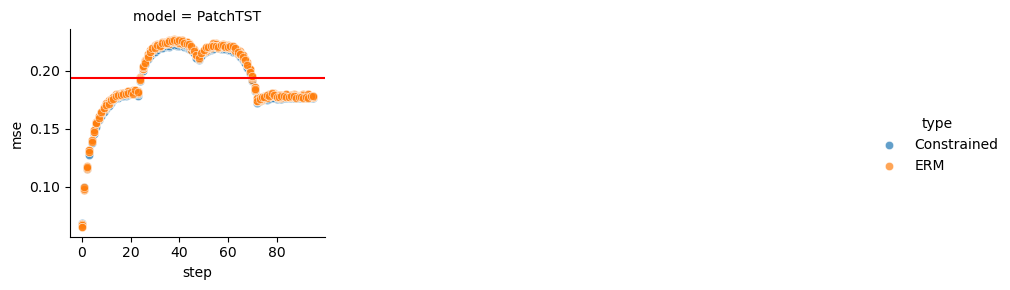

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.166

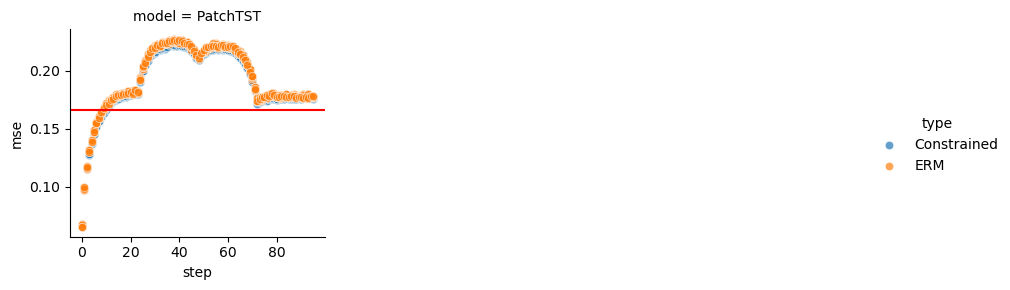

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.15

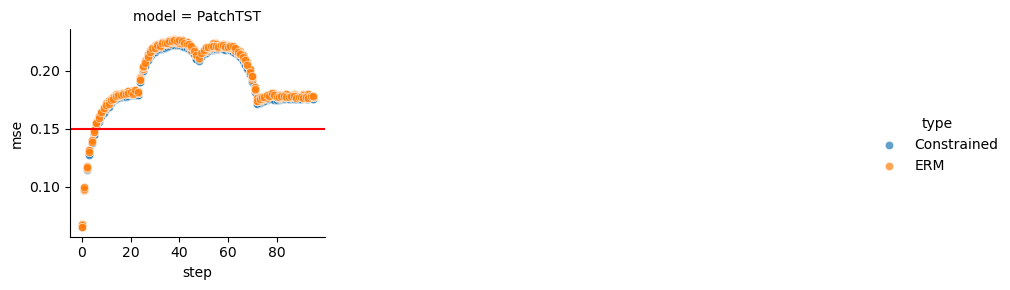

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.17

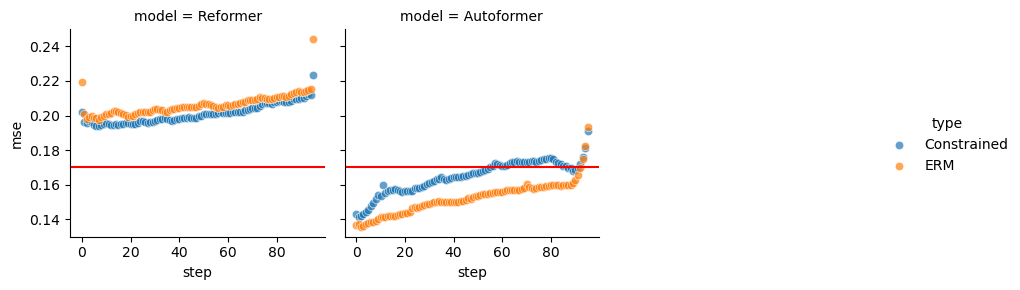

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.169

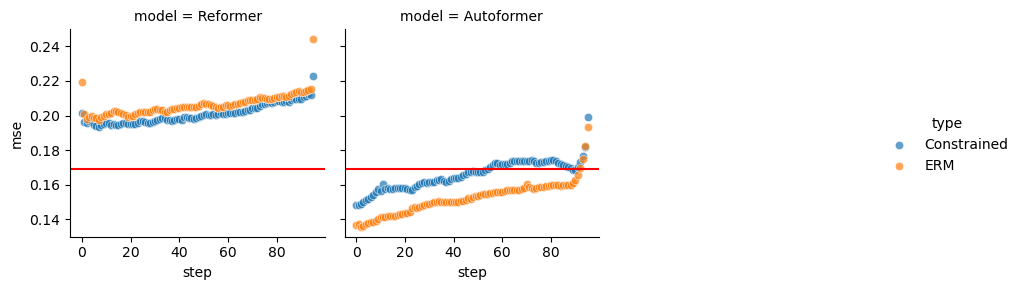

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.157

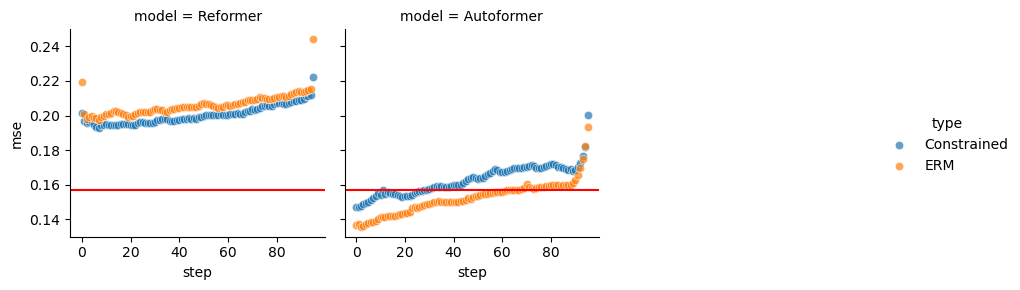

[0.195 0.159 0.151 0.2   0.184 0.173]


### Dataset: electricity.csv pred_len: 192 constraint_level: 0.195

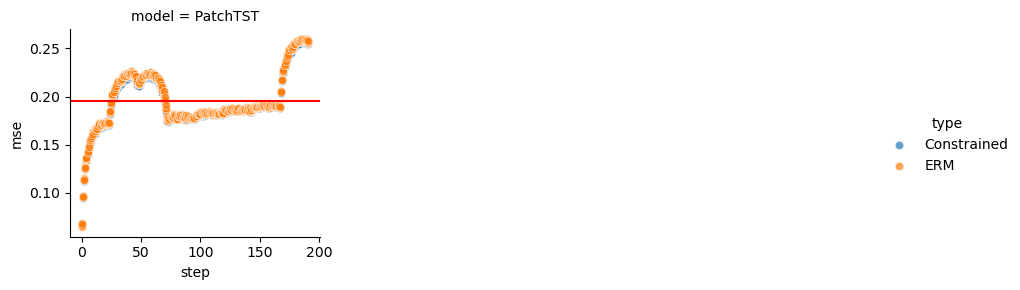

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.159

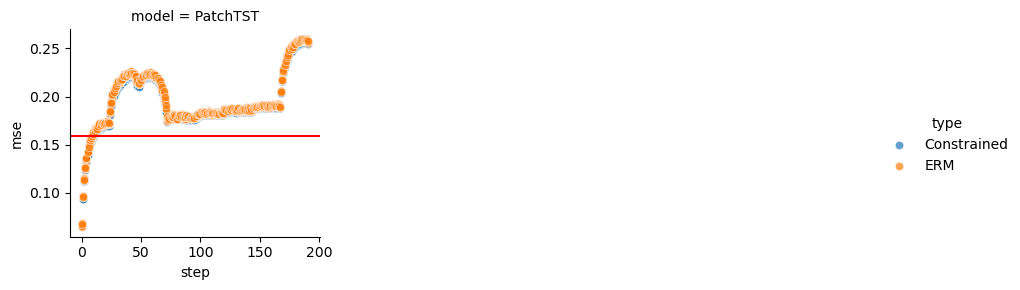

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.151

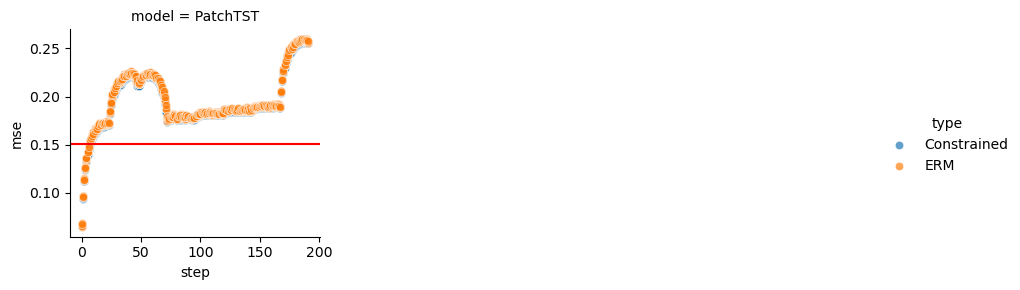

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.2

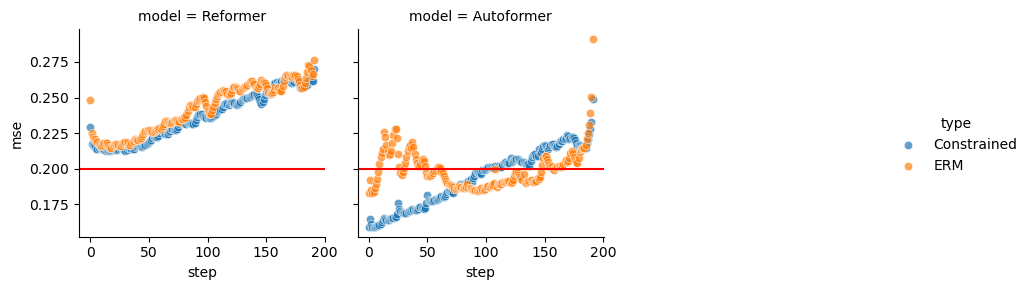

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.184

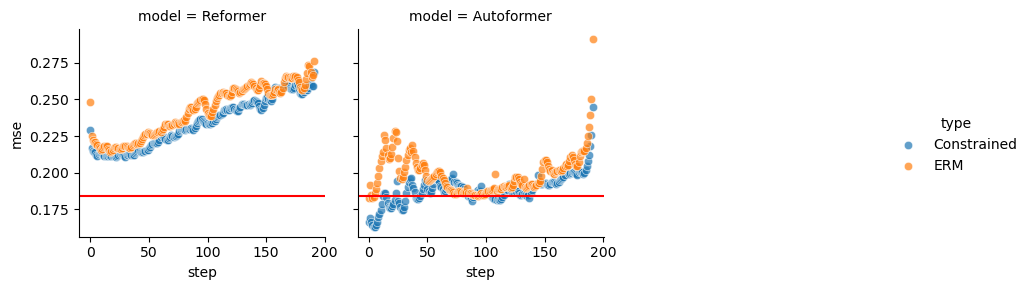

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.173

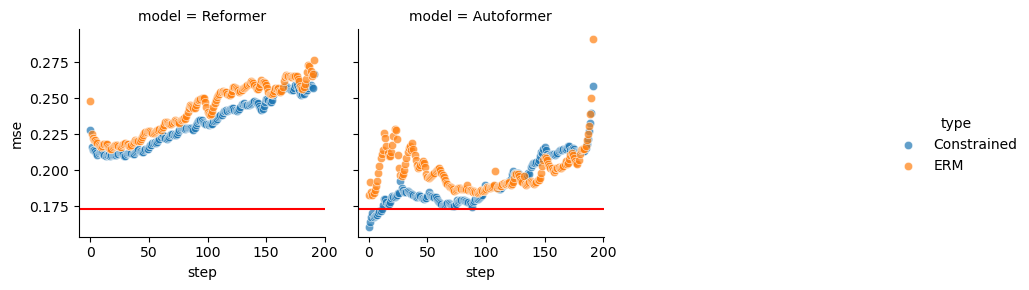

[0.202 0.192 0.155 0.256 0.245 0.232]


### Dataset: electricity.csv pred_len: 336 constraint_level: 0.202

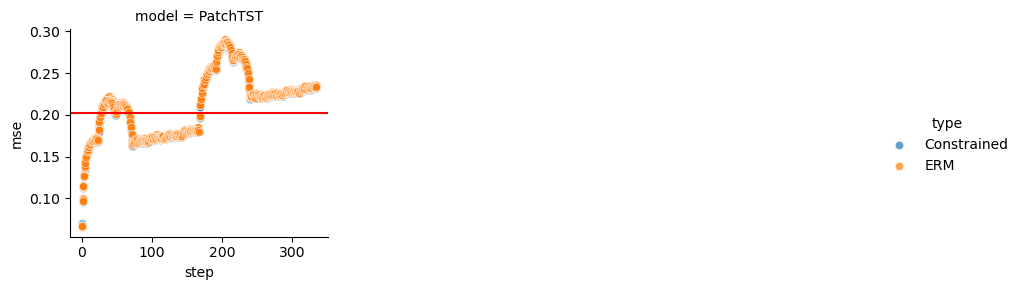

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.192

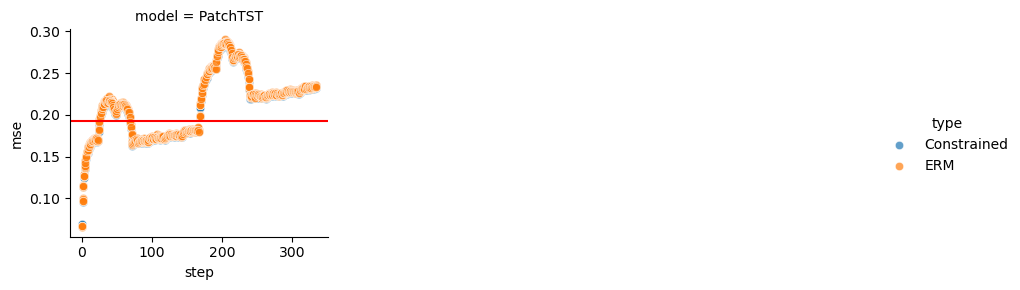

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.155

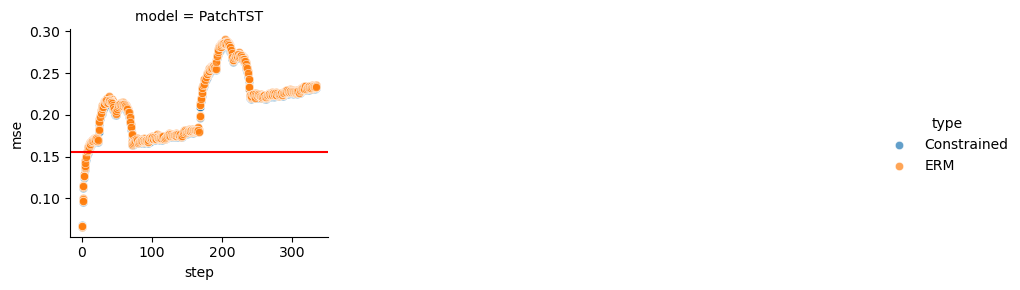

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.256

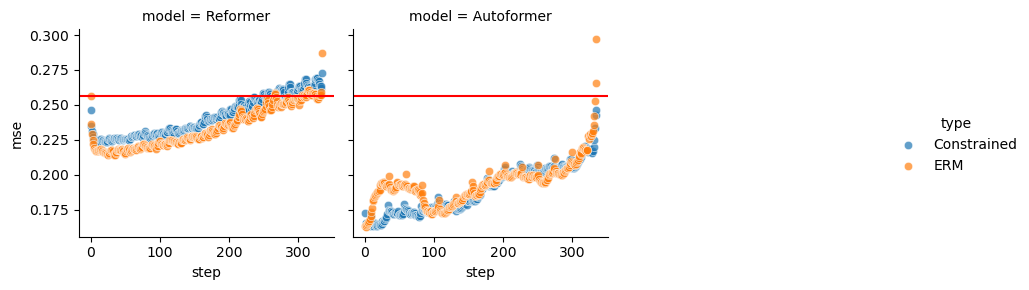

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.245

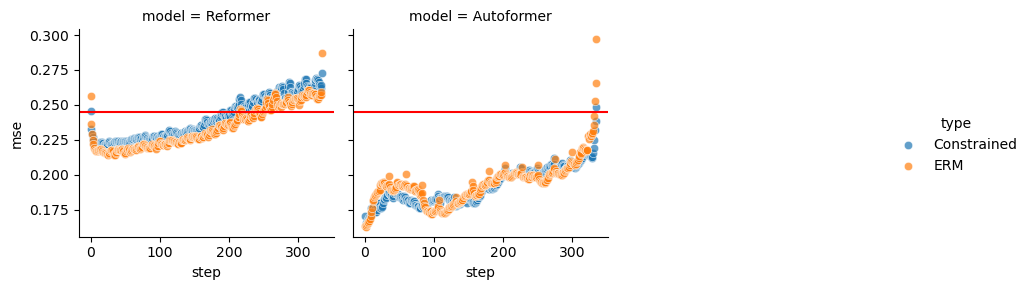

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.232

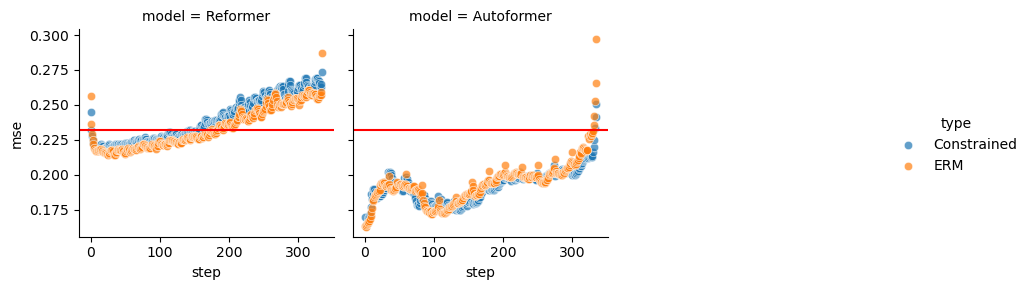

[0.246 0.23  0.215]


### Dataset: electricity.csv pred_len: 720 constraint_level: 0.246

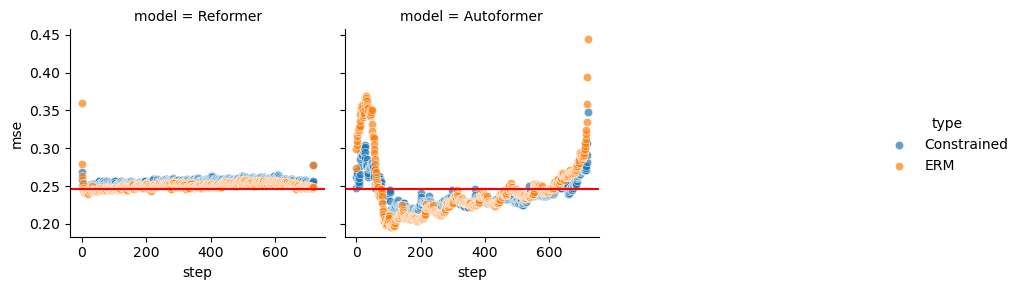

### Dataset: electricity.csv pred_len: 720 constraint_level: 0.23

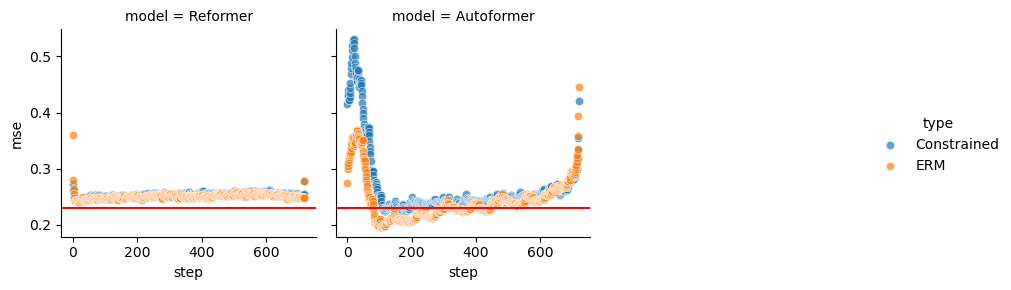

### Dataset: electricity.csv pred_len: 720 constraint_level: 0.215

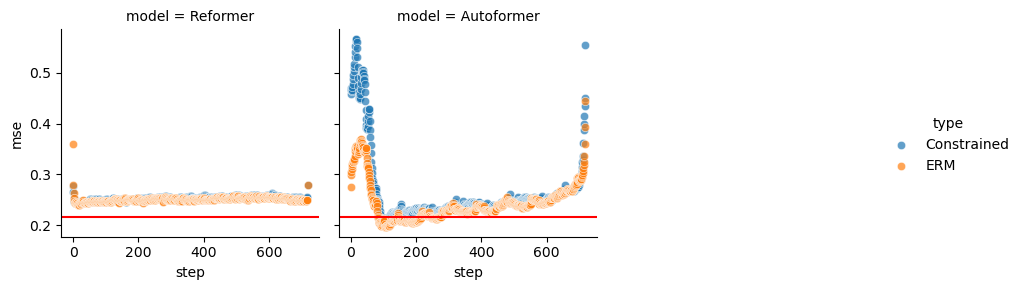

[nan]


### Dataset: exchange_rate.csv pred_len: 96 constraint_level: nan

ValueError: Number of rows must be a positive integer, not 0

<Figure size 900x0 with 0 Axes>

In [19]:
to_plot = df_to_plot[(df_to_plot.split=='test')].copy()
for (data_path,pred_len), series in to_plot.groupby(['data_path',"pred_len"]):
    constraints = series.constraint_level.unique()
    print(constraints)
    constraints = constraints[constraints!=-1] # to iterate over all constraints explored.
    for constraint_level in constraints:
        display(Markdown(f"### Dataset: {data_path} pred_len: {pred_len} constraint_level: {constraint_level}"))
        plot_series = series[series["constraint_level"]==constraint_level]
        
        #means_per_experiment = plot_series.groupby(['pred_len','constraint_level','Algorithm','model','epoch','type'])['mse'].mean().reset_index()
        #display(means_per_experiment)
        # do a pivot where model are the rows, and the columns constrained and unconstrained
        #display(means_per_experiment.pivot(index=['model'], columns='type', values='mse').reset_index())

        # sns.scatterplot(x="step", y="mse", hue="Algorithm",style="split", data=plot_series)
        
        # plt.axhline(y=constraint_level, color='r', linestyle='-')
        # plt.title(f"Pred Length: {pred_len}, Constraint_level: {constraint_level}")
        # plt.show()

        # This same scatterplot but in a grid by algorithm. 
        g = sns.FacetGrid(plot_series, col="model", hue="type",col_wrap=3)
        g.map(sns.scatterplot, "step", "mse", alpha=.7) 
        g.add_legend()
        # add the hline
        for ax in g.axes:
            ax.axhline(y=constraint_level, color='r', linestyle='-')
        plt.show()
        # export this plot to latex. Remove the dot in constraint_level decimal
        g.savefig(f"figures/constrained_vs_erm_{data_path}_{pred_len}_{str(constraint_level).replace('.','')}.png")
        # Fix [Errno 2] No such file or directory: 'figures/electricity.csv_96_0.17_individual.png'


### ERM on multiple algorithms
As a front page chart to illustrate the problem

In [ ]:
#TODO ( I think Nacho already did this)

### Loss shaping single instance qualitative analysis

### Plotting dual variables

In [20]:
df_to_plot[['run_id','pred_len','constraint_level','data_path','model','type']].drop_duplicates().query("data_path=='weather.csv' and model=='Reformer' and type=='Constrained'")

,run_id,pred_len,constraint_level,data_path,model,type
109872,p9izzn2r,96,0.556,weather.csv,Reformer,Constrained
110160,b1adswkj,96,0.553,weather.csv,Reformer,Constrained
110448,dowv2wrc,96,0.516,weather.csv,Reformer,Constrained
110736,i7gx5ivx,192,0.665,weather.csv,Reformer,Constrained
111312,v4rwuch4,192,0.567,weather.csv,Reformer,Constrained
111888,mitm69y2,192,0.553,weather.csv,Reformer,Constrained
112464,chbkcq99,336,0.970,weather.csv,Reformer,Constrained
113472,749ywu49,336,0.741,weather.csv,Reformer,Constrained
114480,fe29o3il,336,0.682,weather.csv,Reformer,Constrained
115488,n1dluqy8,720,0.912,weather.csv,Reformer,Constrained


In [21]:
constrained_runs = df_to_plot.query('type=="Constrained"').copy()
# Sum the multilpiers, fill with 0
key_cols=['run_id','model','pred_len','constraint_level','data_path']
multiplier_sum=constrained_runs.groupby(key_cols)['multiplier'].sum().reset_index()

#TO DO: plot MSE 
# get test mse
test_mses=constrained_runs.query('split=="test"').groupby(key_cols)['mse'].mean().reset_index()
mult_vs_test_mse=multiplier_sum.merge(test_mses,on=key_cols)
#sns.scatterplot(x="multiplier", y="mse", hue="constraint_level",style="pred_len", data=mult_vs_test_mse)
#g = sns.FacetGrid(mult_vs_test_mse, col="model",row='data_path',style="pred_len")
# scatterplot with hue="constraint_level",style="pred_len"
#g.map(sns.scatterplot, "multiplier", "mse", alpha=.7,)#sns.scatterplot(**args,hue="constraint_level",style="pred_len",alpha=0.3)
#g.map(sns.scatterplot, "multiplier", "mse",alpha=.7)

In [22]:
# #df_to_plot.query('split=="train" and pred_len==96').run_id.head(1)
# #mult_cols = [f"multiplier/{i}" for i in range(0,96)]
# # Plot for every constraint level in the 96 pred len window
# #for pred_len in df_to_plot.pred_len.unique():
# display(Markdown(f"# Multipliers for window of {pred_len}"))
# # sns.scatterplot(x="step", y="multiplier", hue="model",style="constraint_level", 
# #     data=df_to_plot.query(f"split=='train' and type=='Constrained' and pred_len=={96} and data_path=='weather.csv'"))
# # same plot, but grid with one plot per model
# dd = df_to_plot#df_to_plot.query("run_id=='6fgam2dx' and split=='train'")#.query(f"split=='train' and type=='Constrained' and pred_len==96 and data_path=='electricity.csv' and model=='Reformer' and constraint_level==0.157")
# dd_test = df_to_plot#df_to_plot.query("run_id=='6fgam2dx' and split=='test'")#.query(f"split=='test' and type=='Constrained' and pred_len==96 and data_path=='electricity.csv' and model=='Reformer' and constraint_level==0.157")

# #print(dd_test.constraint_level.unique())
# test_set_plus_multipliers = dd[['step','multiplier']].merge(dd_test[['step','split','mse']],on='step')

# unioned = pd.concat([dd[['step','split','multiplier','mse']],test_set_plus_multipliers[['step','split','multiplier','mse']]])

# display(unioned)


# display(test_set_plus_multipliers)

# #constraint_level==0.553
# # mult on x, mse@train and mse@test on y. hue=split
# # Add step over every point
# sns.scatterplot(unioned,x="multiplier", y="mse",hue='split', alpha=.3,legend='full')



# g = sns.FacetGrid(dd, col="model", row="constraint_level")
# g.map(sns.scatterplot, "step", "multiplier", alpha=.3)
# #g.map(sns.scatterplot, "step", "mse", alpha=.3)

### More random explorations
Ideas: 
1. Loss over time
2. Infeasibility rate over time
3. Loss shape across epochs (see how it evolves)
4. Plotting dual variables

## Result tables
1. Reproduce the pivot table from notebook 11, perhaps add standard deviation reports.
2. Explore and find other interesting table visualziation

In [25]:
#Note, variance is nan because there is only one run per parameter set
weather = summary_metrics.query('data_path=="weather.csv"').copy()
electricity = summary_metrics.query('data_path=="electricity.csv"').copy()
for name,dataset in [('weather',weather), ('electricity',electricity)]:
    display(Markdown(f"# {name}"))
    tp2=dataset.copy(deep=True)
    #tp2=weather.query('split=="test"').copy()
    # Compute 'infeasible amount' as the difference between the mse and the constraint_level, 0 if mse < constraint
    #tp2['mean_violation']=tp2.apply(lambda x: max(0,x['mse']-x['constraint_level']),axis=1)
    
    # Split into constrained and ERM
    tp2_constrained=tp2.query('type=="Constrained"').copy()
    tp2_erm_baseline=tp2.query('type=="ERM"').copy()

    distinct_constraints = tp2_constrained[['pred_len','model','constraint_level']].drop_duplicates()

    # crossjoin the ERM mse to all constraint levels
    #tp2_erm_baseline_broadcasted = tp2_erm_baseline.drop(columns=['constraint_level']).merge(distinct_constraints,on=['pred_len','model'],how='left')

    #display(tp2_erm_baseline_broadcasted[['type','model','constraint_level','mse']].head())

    # concat back together to compute mean_violation
    #tp2=pd.concat([tp2_constrained,tp2_erm_baseline_broadcasted],axis=0)

    #tp2['mean_violation']=tp2.apply(lambda x: max(0,x['mse']-x['constraint_level']),axis=1)

    # Sanity check show the mean_violation for the ERM runs
    #display(tp2.query('type=="ERM"')[['type','model','constraint_level','mse','mean_violation']].head())


    #GROUPING TEH VALS
    grouped_values=tp2.groupby(['pred_len','constraint_level','model','type'])[[
        'mse','mcv',
        'std_mse','std_mcv',
        'mean_infeasible_rate','std_infeasible_rate']].mean().reset_index()
    #grouped_constrained = grouped_values[grouped_values.type=='Constrained'].copy()
    #grouped_erm_baseline=grouped_values[grouped_values.type=='ERM'].copy()

    # best_constraints is the constraint for each model and pred_len that minimizes mean_violation. show min and argmin
    #best_constraints_per_window = grouped_values.query('type=="Constrained"').groupby(['pred_len']).apply(lambda x: x.loc[x['mean_violation'].idxmin()]).reset_index(drop=True)[['pred_len','type','constraint_level','mean_violation','mse']]
    # instead of best constraints, show all constraint levels.

    # join best_constraints and grouped_values to get the mse and mean_violation for the best constraint
    #best_constrained=grouped_values.merge(best_constraints_per_window[['pred_len','constraint_level']],on=['pred_len','constraint_level'],how='inner')


    # crossjoin the ERM mse to all constraint levels
    ##grouped_erm_baseline_broadcasted = grouped_erm_baseline.drop(columns=['constraint_level']).merge(grouped_constrained[['pred_len','model','constraint_level']].drop_duplicates(),on=['pred_len','model'],how='left')

    # Pivot of models versus constrained and ERM, values are mse and mse_diff
    all_results = grouped_values#pd.concat([grouped_constrained,grouped_erm_baseline_broadcasted],axis=0)
    # Pivot all results, sort ascending by pred_len, then mean_violation on constrained

    pivoted=all_results.pivot(
        index=['pred_len','constraint_level'], 
        columns=['type','model'], 
        values=['mse','std_mse','mcv','std_mcv','mean_infeasible_rate','std_infeasible_rate']
    ).query('constraint_level>0').round(4)
    simplified = all_results.pivot(
        index=['pred_len','constraint_level'],
        columns=['type','model'],
        values=['mse','mcv']
    )
    pd.set_option('display.max_columns', None)
    print("SIMPLIFIED 192 MSE")
    # show all pred lengths (index)
    for pred_len in [96, 192, 336, 720]:            
        print(simplified.index.get_level_values(0).unique())
        simp_mse_192=simplified[simplified.index.get_level_values(0)==pred_len][['mse']]
        sim_mcv_192=simplified[simplified.index.get_level_values(0)==pred_len][['mcv']]

        # Flatten the multiindex
        def prettify(d):
            d = d.copy()
            d.columns = d.columns.map('_'.join)
            return d.style.format(precision=3)
        # display(prettify(simp_mse_192))
        print(f"SIMPLIFIED {pred_len} MCV")
        display(prettify(sim_mcv_192))
    print("FULL")
    ## deleteme debug block
    if name=='electricity':
        print("picking out for debugging")
        pivoted_electricity=pivoted
    ##
    display(pivoted)
    #reformer works best on weather.

# weather

SIMPLIFIED 192 MSE
Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 96 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 192 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 336 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 720 MCV


FULL


mse                                  \
type                      Constrained      ERM Constrained        ERM   
model                        PatchTST PatchTST  Autoformer Autoformer   
pred_len constraint_level                                               
96       0.408                 0.3669   0.3703         NaN        NaN   
         0.487                 0.3696   0.3703         NaN        NaN   
         0.516                    NaN      NaN      0.4787     0.4482   
         0.520                 0.3714   0.3703         NaN        NaN   
         0.553                    NaN      NaN      0.4756     0.4482   
         0.556                    NaN      NaN      0.4748     0.4482   
192      0.553                    NaN      NaN      0.6139     0.5941   
         0.567                    NaN      NaN      0.5868     0.5941   
         0.665                    NaN      NaN      0.5952     0.5941   
336      0.682                    NaN      NaN      0.7118     0.6704   
         0.741                    NaN      NaN      0.6518     0.6704   
         0.970                    NaN      NaN      0.6572     0.6704   
720      0.698                    NaN      NaN      0.7879     0.7840   
         0.862                    NaN      NaN      0.7923     0.7840   
         0.912                    NaN      NaN      0.7926     0.7840   

                                                   std_mse           \
type                      Constrained      ERM Constrained      ERM   
model                        Reformer Reformer    PatchTST PatchTST   
pred_len constraint_level                                             
96       0.408                    NaN      NaN      0.0010   0.0019   
         0.487                    NaN      NaN      0.0029   0.0019   
         0.516                 0.4345   0.4380         NaN      NaN   
         0.520                    NaN      NaN      0.0017   0.0019   
         0.553                 0.4377   0.4380         NaN      NaN   
         0.556                 0.4380   0.4380         NaN      NaN   
192      0.553                 0.4737   0.4877         NaN      NaN   
         0.567                 0.4767   0.4877         NaN      NaN   
         0.665                 0.5055   0.4877         NaN      NaN   
336      0.682                 0.5596   0.6312         NaN      NaN   
         0.741                 0.5794   0.6312         NaN      NaN   
         0.970                 0.6335   0.6312         NaN      NaN   
720      0.698                 0.7066   0.6350         NaN      NaN   
         0.862                 0.7185   0.6350         NaN      NaN   
         0.912                 0.7234   0.6350         NaN      NaN   

                                                                       \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.408                    NaN        NaN         NaN      NaN   
         0.487                    NaN        NaN         NaN      NaN   
         0.516                    NaN        NaN         NaN      NaN   
         0.520                    NaN        NaN         NaN      NaN   
         0.553                    NaN        NaN         NaN      NaN   
         0.556                    NaN        NaN         NaN      NaN   
192      0.553                    NaN        NaN         NaN      NaN   
         0.567                    NaN        NaN         NaN      NaN   
         0.665                    NaN        NaN         NaN      NaN   
336      0.682                    NaN        NaN         NaN      NaN   
         0.741                    NaN        NaN         NaN      NaN   
         0.970                    NaN        NaN         NaN      NaN   
720      0.698                    NaN        NaN         NaN      NaN   
         0.862                    NaN        NaN       

# electricity

SIMPLIFIED 192 MSE
Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 96 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 192 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 336 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 720 MCV


FULL
picking out for debugging


mse                                  \
type                      Constrained      ERM Constrained        ERM   
model                        PatchTST PatchTST  Autoformer Autoformer   
pred_len constraint_level                                               
96       0.150                 0.1883   0.1916         NaN        NaN   
         0.157                    NaN      NaN      0.1507     0.1400   
         0.166                 0.1884   0.1916         NaN        NaN   
         0.169                    NaN      NaN      0.1541     0.1400   
         0.170                    NaN      NaN      0.1520     0.1400   
         0.194                 0.1889   0.1916         NaN        NaN   
192      0.151                 0.1903   0.1931         NaN        NaN   
         0.159                 0.1902   0.1931         NaN        NaN   
         0.173                    NaN      NaN      0.1763     0.1827   
         0.184                    NaN      NaN      0.1742     0.1827   
         0.195                 0.1906   0.1931         NaN        NaN   
         0.200                    NaN      NaN      0.1798     0.1827   
336      0.155                 0.2078   0.2107         NaN        NaN   
         0.192                 0.2080   0.2107         NaN        NaN   
         0.202                 0.2082   0.2107         NaN        NaN   
         0.232                    NaN      NaN      0.1849     0.1832   
         0.245                    NaN      NaN      0.1869     0.1832   
         0.256                    NaN      NaN      0.1851     0.1832   
720      0.215                    NaN      NaN      0.2379     0.2235   
         0.230                    NaN      NaN      0.2400     0.2235   
         0.246                    NaN      NaN      0.2241     0.2235   

                                                   std_mse           \
type                      Constrained      ERM Constrained      ERM   
model                        Reformer Reformer    PatchTST PatchTST   
pred_len constraint_level                                             
96       0.150                    NaN      NaN      0.0004   0.0003   
         0.157                 0.1824   0.1881         NaN      NaN   
         0.166                    NaN      NaN      0.0005   0.0003   
         0.169                 0.1832   0.1881         NaN      NaN   
         0.170                 0.1833   0.1881         NaN      NaN   
         0.194                    NaN      NaN      0.0003   0.0003   
192      0.151                    NaN      NaN      0.0003   0.0003   
         0.159                    NaN      NaN      0.0003   0.0003   
         0.173                 0.2074   0.2150         NaN      NaN   
         0.184                 0.2086   0.2150         NaN      NaN   
         0.195                    NaN      NaN      0.0001   0.0003   
         0.200                 0.2108   0.2150         NaN      NaN   
336      0.155                    NaN      NaN      0.0002   0.0003   
         0.192                    NaN      NaN      0.0001   0.0003   
         0.202                    NaN      NaN      0.0002   0.0003   
         0.232                 0.2163   0.2112         NaN      NaN   
         0.245                 0.2177   0.2112         NaN      NaN   
         0.256                 0.2192   0.2112         NaN      NaN   
720      0.215                 0.2284   0.2250         NaN      NaN   
         0.230                 0.2295   0.2250         NaN      NaN   
         0.246                 0.2325   0.2250         NaN      NaN   

                                                                       \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.150                    NaN        NaN         NaN      NaN   
         0.157                    NaN        NaN         NaN      N

In [29]:
pivoted_electricity

mse                                  \
type                      Constrained      ERM Constrained        ERM   
model                        PatchTST PatchTST  Autoformer Autoformer   
pred_len constraint_level                                               
96       0.150                 0.1883   0.1916         NaN        NaN   
         0.157                    NaN      NaN      0.1507     0.1400   
         0.166                 0.1884   0.1916         NaN        NaN   
         0.169                    NaN      NaN      0.1541     0.1400   
         0.170                    NaN      NaN      0.1520     0.1400   
         0.194                 0.1889   0.1916         NaN        NaN   
192      0.151                 0.1903   0.1931         NaN        NaN   
         0.159                 0.1902   0.1931         NaN        NaN   
         0.173                    NaN      NaN      0.1763     0.1827   
         0.184                    NaN      NaN      0.1742     0.1827   
         0.195                 0.1906   0.1931         NaN        NaN   
         0.200                    NaN      NaN      0.1798     0.1827   
336      0.155                 0.2078   0.2107         NaN        NaN   
         0.192                 0.2080   0.2107         NaN        NaN   
         0.202                 0.2082   0.2107         NaN        NaN   
         0.232                    NaN      NaN      0.1849     0.1832   
         0.245                    NaN      NaN      0.1869     0.1832   
         0.256                    NaN      NaN      0.1851     0.1832   
720      0.215                    NaN      NaN      0.2379     0.2235   
         0.230                    NaN      NaN      0.2400     0.2235   
         0.246                    NaN      NaN      0.2241     0.2235   

                                                   std_mse           \
type                      Constrained      ERM Constrained      ERM   
model                        Reformer Reformer    PatchTST PatchTST   
pred_len constraint_level                                             
96       0.150                    NaN      NaN      0.0004   0.0003   
         0.157                 0.1824   0.1881         NaN      NaN   
         0.166                    NaN      NaN      0.0005   0.0003   
         0.169                 0.1832   0.1881         NaN      NaN   
         0.170                 0.1833   0.1881         NaN      NaN   
         0.194                    NaN      NaN      0.0003   0.0003   
192      0.151                    NaN      NaN      0.0003   0.0003   
         0.159                    NaN      NaN      0.0003   0.0003   
         0.173                 0.2074   0.2150         NaN      NaN   
         0.184                 0.2086   0.2150         NaN      NaN   
         0.195                    NaN      NaN      0.0001   0.0003   
         0.200                 0.2108   0.2150         NaN      NaN   
336      0.155                    NaN      NaN      0.0002   0.0003   
         0.192                    NaN      NaN      0.0001   0.0003   
         0.202                    NaN      NaN      0.0002   0.0003   
         0.232                 0.2163   0.2112         NaN      NaN   
         0.245                 0.2177   0.2112         NaN      NaN   
         0.256                 0.2192   0.2112         NaN      NaN   
720      0.215                 0.2284   0.2250         NaN      NaN   
         0.230                 0.2295   0.2250         NaN      NaN   
         0.246                 0.2325   0.2250         NaN      NaN   

                                                                       \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.150                    NaN        NaN         NaN      NaN   
         0.157                    NaN        NaN         NaN      N

In [ ]:
pivoted_electricity[[]]

## Pivots per dataset